# Theis Pumping Test Analysis

This notebook will solve the equations for pumping test analysis in a confined aquifer. 

After the definition of variables, the value u is computed:

$$ u = \frac{r^2 \cdot S} {4 T t} $$

Python libraries for operating system functions, for numerical computation, for scientific constants and functions, for mathematical functions and for plotting are loaded.

In [323]:
import os
import numpy
import scipy
import math
import matplotlib.pyplot as plt

The parameters for the pumping test are loaded: $h_=$ is the water level at the start, here 10 m. $Q_p$ is the pumping rate in $\frac{m^3}{s}$, note per second to stay within SI units (!), $S_s$ is the specific storativity (default is $10^{-4}$), $k_f$ is the hydraulic conductivity in $m/s$, $H_a$ is the aquifer thickness in m, $T_a$ the transmissivity calculated as $H_a \cdot k_f$. Finally, we define a range of values for the radius from the borehole in m (avoiding the value 0 as the drawdown is not defined at r=0) and we define a time range in seconds (to stay within SI units) from 1 minute (60 seconds) to a full day (86400 seconds). 

Comments are added with #.

In [428]:
h0 = 10 # water level at start given in meters
Qp = 0.02 # pumpint rate in m³/s
Ss = 1.4E-4 # specific storage 
kf = 8E-5 # hydraulic conductivity in m/s
Ha = 60 # thickness of the aquifer in m
Ta = kf*H # transmissivity
rb = numpy.arange(1, 100, 1) # distance from the borehole
ts = numpy.arange(60, 86401, 60) # time after start of pumping test

According to theory, we first calculate $u$. Note, that here we take the element that has the index 20 (the index starts with 0, hence, it is element number 21) for $r_b$ and the element with index 60 of time $t_s$, again the sixty-first (as we start from 0).  

In [429]:
u = rb[20]**2*Ss/(4*Ta*ts[60])

After the value of $u$ has been calculated for a given combination of parameters, the value of $u$ is inserted into the well function. Note that the function for the natural logarithm is log2() from the math library and that factorial is calculated with factorial() from the same library:

$$ W(u) = -0.5772-ln(u)+u-\frac{u^2}{2 \cdot 2!}+\frac{u^3}{3\cdot 3!}$$

In the code, an explicit line break \ is used.

In [430]:
wu=-0.5772-math.log2(u)+u \
   -u**2/(2*math.factorial(2)) \
   +u**3/(3*math.factorial(3))

Now, the drawdown can be calculated simply by using the function:
$$s = \frac{Q}{4 \cdot \pi \cdot T} \cdot W(u)$$

In [431]:
s = Qp/(4*math.pi*Ta)*wu

Finally, the computed drawdown is abstracted from the initial water level $h_0$.

$h = h_0-s$

We will now make the program more modular by introducing functions for the calculation of u (called fu), w (called (fw), s (called fs) and h (falled fh). Finally, all funcions are integrated into a function Theis (called ftheis). Please note that a function is defined with **def**, then the function name that can be any string that is not a python key word or that has not been used before as a variable name. In the brackets, there are the variables needed in the function, please note, some rules. You should keep the order, in which they are listed. When you call the function, you transfer parameters into the function. You can define default values (such as Ha=100) in the definition, if you want, the the variable does not have to be called. If you do so, the variables without default values must come first (like the pumping rate $Q_p$ in the function ftheis(Qp). Since in this function, all other variables have default values, you could call the function with ftheis(0.0138), but you could also call it with ftheis(0.0138,10,100,1E-4,10,1E-4,3600), then the drawdown is given for a pumping rate of 0.0138 m³/s, an initial level of 10 m, an aquifer thickness of 100 m, a hydraulic conductivity of 1E-4, at a distance of 10 m, with a Specific Storativiy of 1E-4 and after 3600 seconds.  

Values are explicitely returned with the command **return**.

In [432]:
def fu(Ha,kf,rb,Ss,ts):
    Ta = Ha*kf
    u = rb**2*Ss/(4*Ta*ts)
    return u

In [433]:
def fw(u):
    w=-0.5772-math.log2(u)+u-u**2/(2*math.factorial(2))+u**3/(3*math.factorial(3))
    return w

In [434]:
def fs(w):
    s = Qp/(4*math.pi*Ta)*w
    return s

In [435]:
def fh(h0,s):
    h = h0-s
    return h

In [436]:
def ftheis(Qp,h0=0,Ha=100,kf=1E-4,rb=10,Ss=1E-4,ts=3600):
    u=fu(Ha,kf,rb,Ss,ts)
    w=fw(u)
    s=fs(w)
    h=fh(h0,s)
    return h

Finally, we write the code for producing the table that is similar to the Excel file. We measure the length of the array with radii and call it lr, the same for the time. We now initialize empty tables to receive the data. What is new: We also define a counter cr, and ct and initialize it. Now the for-loops are defined, using ri as the i-th element of the array rb and ti as the i-th element of the array ts. Inside the loop, it is checked whether are are within the indices. We use the functions fu, fw, fs, and fh as well as ftheis, that have been defined before. The values u,w,s, and h are assigned to the arrays mu, mw, ms, mh, and mht at the locations given by the indices cr and ct. I used the functions one after the other and I used the integral function ftheis - just one way is necessary. We stop the loop with the command **break** if we should exceed it by any chance. Finally, one we got out of the first loop, we have to reset the counter for the inner for-loop with **ct=0** and we must increment the counter for the outer loop with **cr=cr+1**.

In [437]:
lr = len(rb)
lt = len(ts)
mu = numpy.zeros((lr,lt), dtype=numpy.float64)
mw = numpy.zeros((lr,lt), dtype=numpy.float64)
ms = numpy.zeros((lr,lt), dtype=numpy.float64)
mh = numpy.zeros((lr,lt), dtype=numpy.float64)
mht = numpy.zeros((lr,lt), dtype=numpy.float64)
cr = 0
ct = 0
for ri in rb:
    for tj in ts:
        if cr <= lr-1 and ct <= lt-1:
            u = fu(Ha,kf,ri,Ss,tj)
            w = fw(u)
            s = fs(w)
            h = fh(h0,s)
            mu[cr,ct] = u
            mw[cr,ct] = w
            ms[cr,ct] = s
            mh[cr,ct] = h
            mht[cr,ct] = ftheis(Qp,h0,Ha,kf,ri,Ss,tj)
            ct = ct+1
        else: 
            break # the break command exits the for-loop 
    ct = 0  # we leave the inner loop and need to reset the counter ct
    cr = cr+1 # we increase the counter for the distance cr

Finally, we plot the data with the library **matplotlib** that contains a function **pyplot**, that has been imported and labelled with a shorter expression **plt**. We can therefore call the function **plt.plot**, it requires a time series. We plot the water levels in the matrix **mh** at the distance of 10 m (first index i in m[**i**,j], and we use all the times from the first to 1430 with the index range m[10,**1:1439**]. Please note, the times are listed with a time step of 60 seconds, hence, the correspond to minutes. At the location of the index, we find the water level **h**, that has been computed.The graph gets an xlabel and a ylabel and - of course - we shot it. 

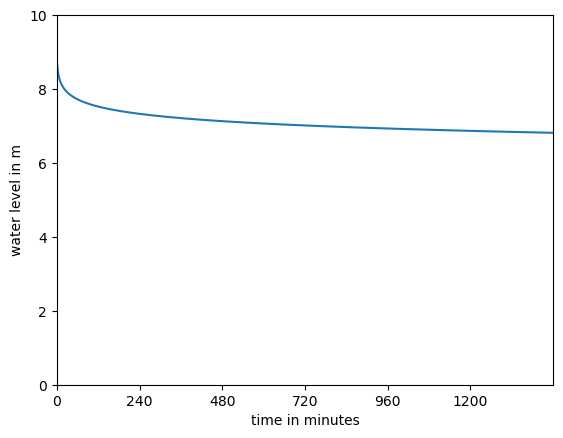

In [438]:
plt.plot(mh[10,1:1439])
plt.xlim([0,1440])
plt.xticks(numpy.arange(0,1440,240), numpy.arange(0, 1440, 240))
plt.ylim([0,10])
plt.xlabel("time in minutes")
plt.ylabel('water level in m')
plt.show()

In the same manner, the matrix mh (or mth, when the full Theis function ftheis is used, just or testing), can be used to plot the water level at different distances. For this purpose we use a range of the first index in mh[0:100,1439]. The first index i with 0:100 specifies the distances r, the second index j specifies the fixed time: As we increment with steps of 60 seconds when we define the variable ts = arange(60,86400,1439), each increment of the index corresponds to 60 seconds or one minute. At j=1439 we are at 1 day after the start of pumping (please not that the index starts with 0, hence index 1439 corresponds to 1440 minutes = 1 day.

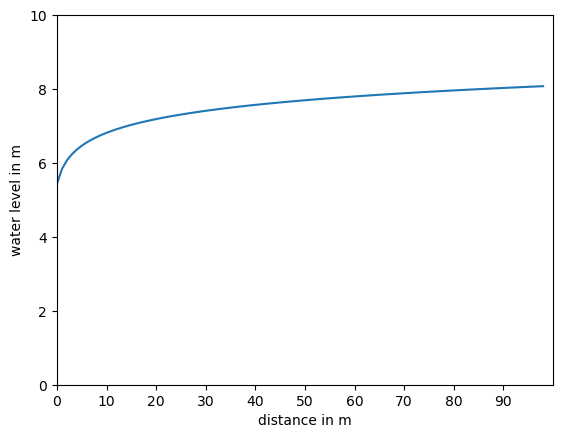

In [439]:
plt.plot(mh[0:100,1439])
plt.xlim([0,100])
plt.xticks(numpy.arange(0,100,10), numpy.arange(0, 100, 10))
plt.ylim([0,10])
plt.xlabel("distance in m")
plt.ylabel('water level in m')
plt.show()

Finally, we try the new function **ftheis()**. First, we call it with only the non-default value for the pumping rate. All other values are set as default. 

In [384]:
ftheis(0.01)

-15.800087838405927

If you want to specify just some (and keep the default values for the others), you must use the variable names and assign values to them. If you do that, you could even mix the variables of the function.

In [385]:
ftheis(0.01, kf=0.001, Ha=50)

-18.571619028767373

Finally, you can try to specify all other variables. Or you use all variables in the right order without their names, or you need to assign all variable names.

In [386]:
ftheis(0.01,h0=6,Ha=50,kf=1E-5,rb=50,Ss=1E-4,ts=1440)

2.3786358870470363